# Importing Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# load dataset

In [20]:
df = pd.read_csv(r'AAPL.csv')
df.tail()

,Date,Close,High,Low,Open,Volume
1255,2024-12-27,255.59,258.70001,253.06000,257.82999,42355300
1256,2024-12-30,252.20,253.50000,250.75000,252.23000,35557500
1257,2024-12-31,250.42,253.28000,249.42999,252.44000,39480700
1258,2025-01-02,243.85,249.10001,241.82001,248.92999,55740700
1259,2025-01-03,243.36,244.17999,241.89000,243.36000,40202700


In [21]:

df = df.set_index("Date")[['Open', 'Close','High', 'Low', 'Volume']]

# Convert the index to datetime
df.index = pd.to_datetime(df.index)
df = df.tail(1000)
df.head()

,Open,Close,High,Low,Volume
Date,,,,,
2021-01-13,125.90861,127.9914,128.53904,125.64460,88636800
2021-01-14,127.90344,126.0553,128.09900,125.90860,90221800
2021-01-15,125.92818,124.3245,127.33629,124.18759,111598500
2021-01-19,124.95032,124.9992,125.85973,124.12892,90757300
2021-01-20,125.81085,129.1062,129.55604,125.70328,104319500


# Initialize a MinMaxScaler

In [22]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)
df.head()

,Open,Close,High,Low,Volume
Date,,,,,
2021-01-13,0.065954,0.096771,0.074755,0.082311,0.221368
2021-01-14,0.080040,0.083424,0.071660,0.084147,0.226733
2021-01-15,0.066093,0.071493,0.066296,0.072181,0.299087
2021-01-19,0.059188,0.076144,0.055911,0.071773,0.228545
2021-01-20,0.065264,0.104455,0.081907,0.082719,0.274450


# Normalize the data

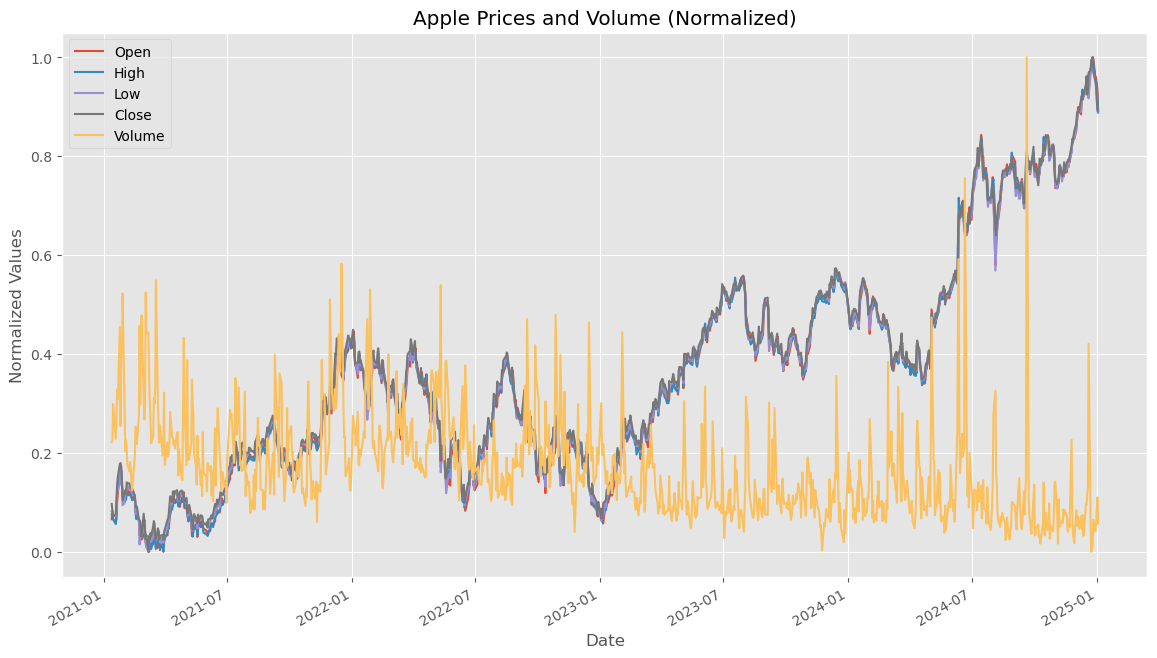

In [23]:
normalized_df = (df - df.min()) / (df.max() - df.min())

# Plot all columns
normalized_df[['Open', 'High', 'Low', 'Close', 'Volume']].plot(figsize=(14, 8))
plt.title('Apple Prices and Volume (Normalized)')
plt.ylabel('Normalized Values')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [24]:
def split_sequences(seq, n_steps_in, n_steps_out):
    """
    Splits a multivariate time series sequence into input (X) and output (y) samples.

    Parameters:
    - seq: A 2D array where each row is a time step, and columns are features.
    - n_steps_in: Number of time steps in the input sequence.
    - n_steps_out: Number of time steps in the output sequence.

    Returns:
    - X: 3D numpy array of input sequences (samples, time steps, features).
    - y: 3D numpy array of output sequences (samples, time steps, features).
    """
    X, y = [], []
    
    for i in range(len(seq)):
        # Calculate the end of the input sequence
        end = i + n_steps_in
        # Calculate the end of the output sequence
        out_end = end + n_steps_out
        
        # Break the loop if the end of the sequence is beyond the list length
        if out_end > len(seq):
            break
        
        # Slice the input and output sequences
        seq_x = seq[i:end, :]  # Input sequence (time steps x features)
        seq_y = seq[end:out_end, :]  # Output sequence (time steps x features)
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


In [25]:
def visualize_results(results):
    """
    Visualizes training and validation metrics from the model's history.

    Parameters:
    - results: A Keras History object containing training and validation metrics.
    """
    history = results.history

    # Plot Loss
    if 'loss' in history and 'val_loss' in history:
        plt.figure(figsize=(12, 4))
        plt.plot(history['loss'], label='Training Loss', marker='o')
        plt.plot(history['val_loss'], label='Validation Loss', marker='o')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    # Plot Accuracy (if available)
    if 'accuracy' in history and 'val_accuracy' in history:
        plt.figure(figsize=(12, 4))
        plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()

    # Handle additional metrics dynamically
    for metric in history.keys():
        if metric not in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
            plt.figure(figsize=(12, 4))
            plt.plot(history[metric], label=f'Training {metric.capitalize()}', marker='o')
            if f'val_{metric}' in history:
                plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', marker='o')
            plt.legend()
            plt.title(f'Training and Validation {metric.capitalize()}')
            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.grid(True)
            plt.show()


In [26]:
# Define input and output sequence lengths
n_per_in = 30  # Number of time steps in the input sequence
n_per_out = 10  # Number of time steps in the output sequence

# Extract features
n_features = df.shape[1] 

# Prepare sequences using the modified split_sequences function
X, y = split_sequences(df.values, n_per_in, n_per_out)

# Print the shape of the resulting arrays
print("Original shape of X:", X.shape)
print("Original shape of y:", y.shape)

# Reshape X to 3D for model input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

# Print the reshaped arrays
print("Reshaped X shape:", X.shape)
print("Reshaped y shape:", y.shape)


Original shape of X: (961, 30, 5)
Original shape of y: (961, 10, 5)
Reshaped X shape: (961, 30, 5)
Reshaped y shape: (961, 10, 5)


# LSTM Model

In [27]:
# Define the model
model = Sequential()

# First LSTM layer with relu activation
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_per_in, n_features)))
model.add(Dropout(0.2))

# Second LSTM layer with relu activation
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(30, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(20, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Dense output layer for multivariate regression (predict multiple features)
model.add(Dense(n_per_out * n_features))  
model.add(Reshape((n_per_out, n_features)))  

# Compile the model
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Print model summary
model.summary()


/Users/bibekwagle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 30)         │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 10, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,250 (180.66 KB)

 Trainable params: 46,250 (180.66 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [29]:

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model with callbacks
res = model.fit(
    X, 
    y, 
    epochs=300, 
    batch_size=32, 
    validation_split=0.1, 
    shuffle=True,  # Shuffle the data for better training
    callbacks=[early_stopping, reduce_lr]  # Include both callbacks
)

# Optionally, print the final accuracy
print(f"Final Training Accuracy: {res.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {res.history['val_accuracy'][-1]:.4f}")


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2297 - loss: 0.1043 - val_accuracy: 0.3082 - val_loss: 0.2180 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2087 - loss: 0.0488 - val_accuracy: 0.2443 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2055 - loss: 0.0224 - val_accuracy: 0.3186 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2154 - loss: 0.0156 - val_accuracy: 0.3371 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2091 - loss: 0.0131 - val_accuracy: 0.3825 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2112 - loss: 0.0117 - val_accuracy: 0.3082 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2330 - loss: 0.0111 - 

# Data Visualization

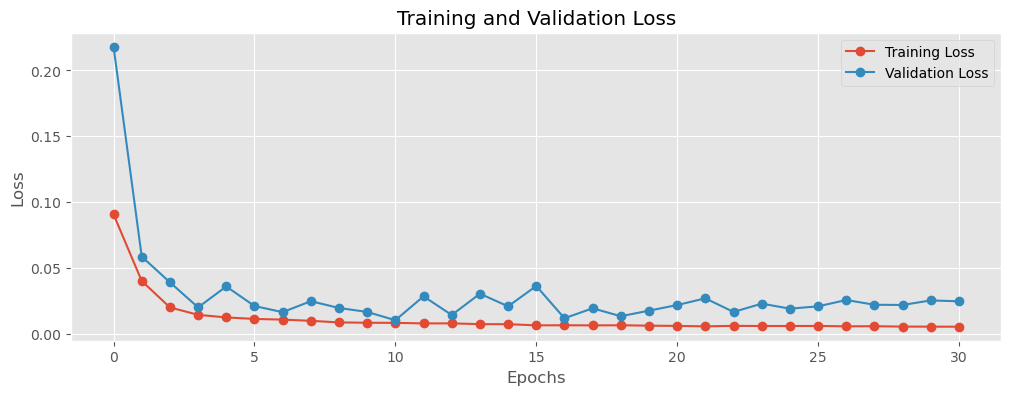

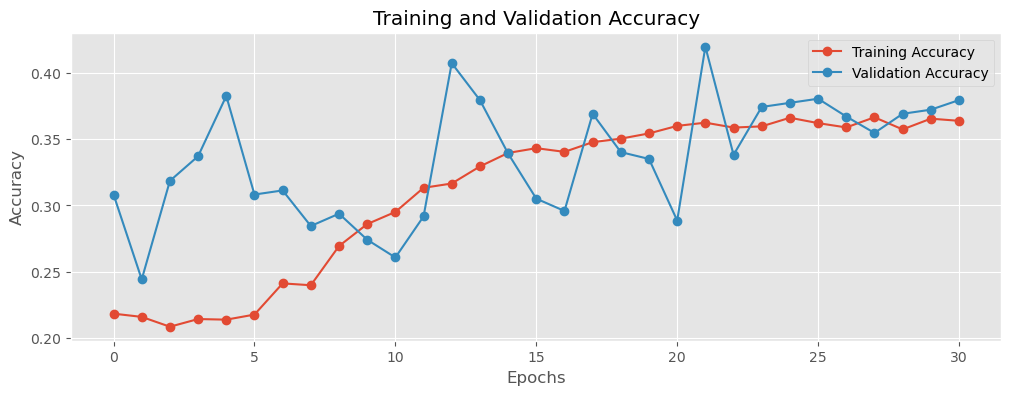

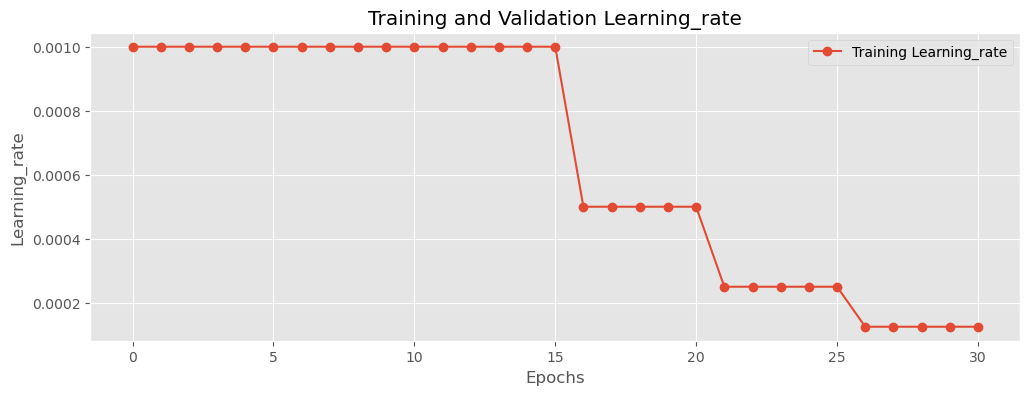

In [30]:
visualize_results(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predicted: [[241.97500610351562], [236.23001098632812], [247.41224670410156], [238.6072540283203], [235.01495361328125], [243.08912658691406], [239.5341796875], [240.30458068847656], [234.4190216064453], [240.15138244628906]]
Actual: [[249.79], [254.49], [255.27], [258.2], [259.02], [255.59], [252.2], [250.42], [243.85], [243.36]]


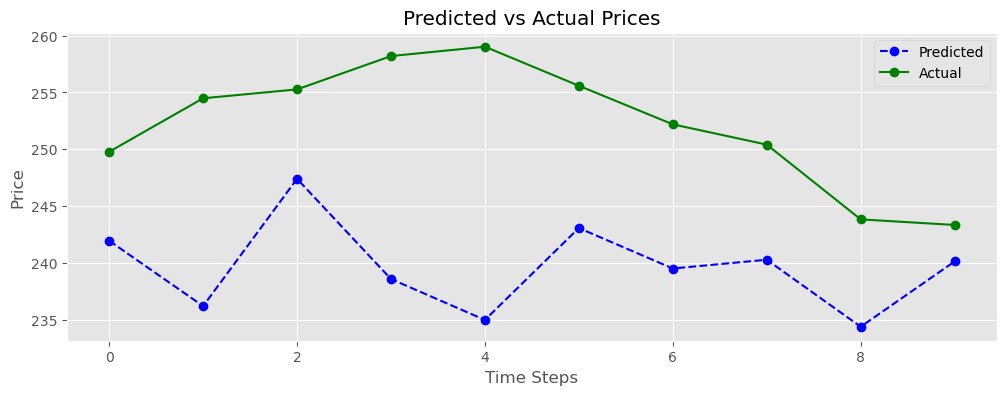

In [31]:
plt.figure(figsize=(12, 4))

# Predict the next values (reshaping the input X[-1])
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)) 

# Inverse transform the predicted values back to the original scale (all features)
yhat_rescaled = scaler.inverse_transform(yhat.reshape(-1, n_features))

# Extract only the 'Close' column for prediction
yhat_close = yhat_rescaled[:, 1].reshape(-1, 1)  

# Convert the inverse transformed predictions to a list
yhat = yhat_close.tolist()

# Get the actual values from the target
actual_rescaled = scaler.inverse_transform(y[-1].reshape(-1, n_features))  # Inverse transform the actual target

# Extract the 'Close' values from actual data
actual_close = actual_rescaled[:, 1].reshape(-1, 1)  # Extract 'Close' from actual values

# Convert the actual values to a list
actual = actual_close.tolist()

# Print predicted and actual values for debugging
print("Predicted:", yhat)
print("Actual:", actual)

# Plot the predicted vs. actual values
plt.plot(yhat, label='Predicted', marker='o', linestyle='--', color='blue')
plt.plot(actual, label='Actual', marker='o', linestyle='-', color='green')

# Plot title and labels
plt.title("Predicted vs Actual Prices")
plt.ylabel('Price')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.show()


# Future Predictions Using model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


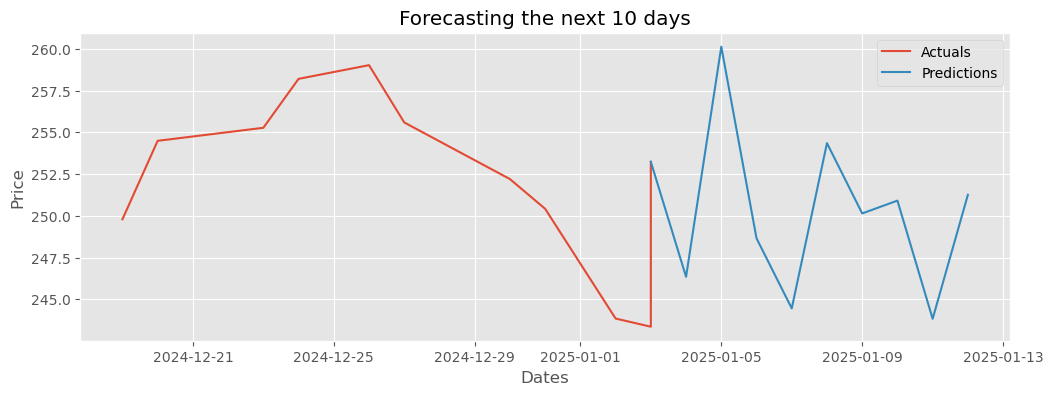

In [32]:
# Prepare the model input with all features (Open, Close, High, Low, Volume)
model_input = np.array(df[['Open', 'Close', 'High', 'Low', 'Volume']].tail(n_per_in)).reshape(1, n_per_in, n_features)

# Predict using the model
yhat = model.predict(model_input)

# Inverse transform the full predictions back to the original scale
# You should use the full scaler (fitted with all features) for inverse transformation
# Ensure to extract only the 'Close' predictions from the result
yhat_close = scaler.inverse_transform(yhat.reshape(-1, n_features))[:, 1].reshape(-1, 1)  # Extract the 'Close' column

# Convert the inverse transformed predictions back to a list
yhat = yhat_close.tolist()

# Creating the predictions DataFrame
preds = pd.DataFrame(
    yhat,
    index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"),
    columns=['Close']
)

# Combining actual and predicted data
periods = 10
actual = pd.concat([
    pd.DataFrame(
        scaler.inverse_transform(df[['Open', 'Close', 'High', 'Low', 'Volume']].tail(periods).values)[:, 1].reshape(-1, 1),  # Extract 'Close' column
        index=df[['Close']].tail(periods).index,
        columns=['Close']
    ),
    preds.head(1)  
])

# Plotting results
plt.figure(figsize=(12, 4))
plt.plot(actual.index, actual['Close'], label='Actuals')
plt.plot(preds.index, preds['Close'], label='Predictions')
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f'Forecasting the next {len(yhat)} days')
plt.legend()
plt.grid(True)
plt.show()